# Local Potential from GPAW

You can perform calcuatiion in any mode. 


In [1]:
from gpaw import GPAW, FermiDirac 
from gpaw.wavefunctions.pw import PW
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

c = 20
PW_cut=400
atoms = read('hBN.cif')
atoms.cell[2,2]=c
atoms.center()

calc = GPAW(mode='fd',xc='PBE',
            kpts={'size': (4, 4, 1)},
            setups='sg15',
            occupations=FermiDirac(0.0001))

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.write('gs_sg15.gpw')


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  1.5.1
 |___|_|             

User:   drg@forsite
Date:   Thu Apr 11 15:15:08 2019
Arch:   x86_64
Pid:    24312
Python: 3.6.7
gpaw:   /usr/local/lib/python3.6/dist-packages/gpaw
_gpaw:  /usr/local/lib/python3.6/dist-packages/
        _gpaw.cpython-36m-x86_64-linux-gnu.so
ase:    /home/drg/.local/lib/python3.6/site-packages/ase (version 3.17.0)
numpy:  /home/drg/.local/lib/python3.6/site-packages/numpy (version 1.16.2)
scipy:  /home/drg/.local/lib/python3.6/site-packages/scipy (version 1.2.1)
units:  Angstrom and eV
cores:  1

Input parameters:
  kpts: {size: (4, 4, 1)}
  occupations: {name: fermi-dirac,
                width: 0.0001}
  setups: sg15
  xc: PBE

System changes: positions, numbers, cell, pbc, initial_charges, initial_magmoms 

Initialize ...

Norm-conserving UPF setup:
  Element:    B
  Z:          5
  Valence:  3.0
Projectors:
  l=0 rcut=1.93
  l=0 rcut=1.93
  l=1 rcut=1.93
  l=1 rcut=

It is possible to extract from GPAW local density $n$ using following code:

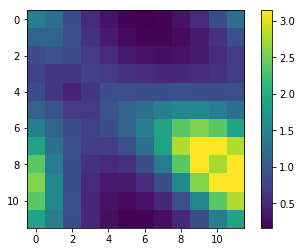

In [2]:
density=calc.density.nt_sG[0].sum(axis=2)
r=calc.wfs.gd.get_grid_point_coordinates()
plt.figure()
plt.imshow(density)
plt.colorbar()

 Also, it is possible to extract from GPAW local potential $V_{HXC}$ using following code:

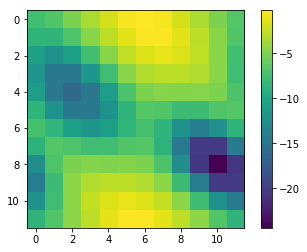

In [3]:
VHXC=calc.hamiltonian.vt_sG[0].sum(axis=2)
r=calc.wfs.gd.get_grid_point_coordinates()
plt.figure()
plt.imshow(VHXC)
plt.colorbar()

To update local potential you should firstly update density by updating wavefunction.

For example, let change wavefunction by applying hamiltonian:
$|\psi_{i+1}>=H_i|\psi_i>$

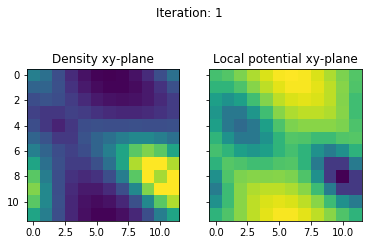

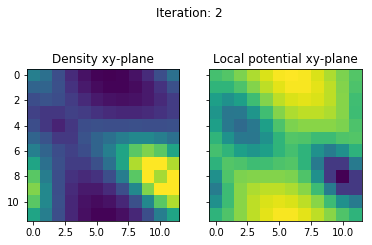

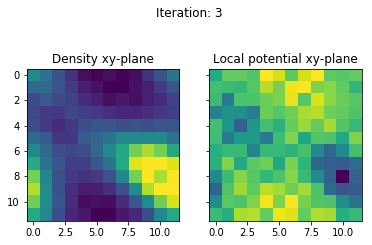

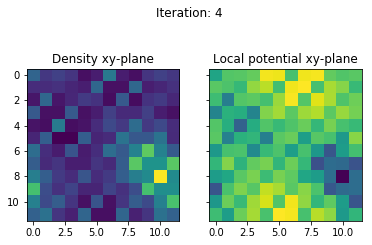

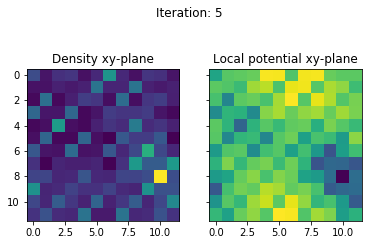

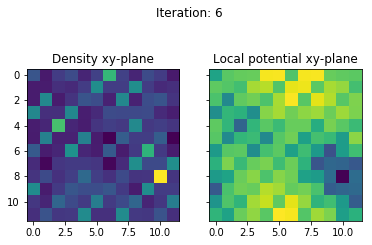

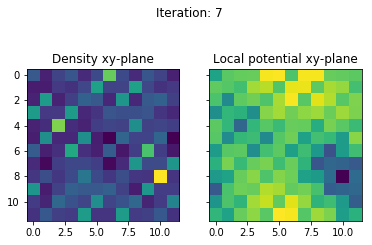

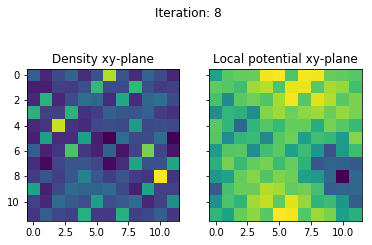

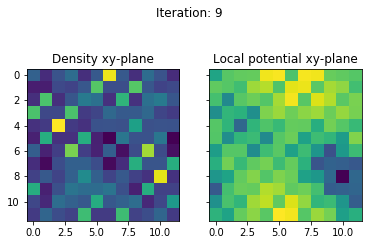

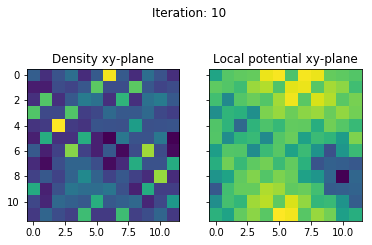

In [4]:
from gpaw.mixer import DummyMixer
#Firstly reset mixing beetween densities
calc.density.set_mixer(DummyMixer())


for i in range(10):
    #updating wavefunction by k-points
    for kpt in calc.wfs.kpt_u:
        psit=np.zeros_like(kpt.psit_nG)
        #apply hamiltonian
        calc.hamiltonian.apply(kpt.psit_nG, psit, calc.wfs, kpt)
        #normaliza wavefunction (I don't belive it is needed)
        for n,psi in enumerate(psit):
            psit[n]/=np.sqrt(calc.wfs.gd.integrate(psit[n],psit[n]))
        #update wavefucntion
        kpt.psit.array[:]=psit
    #update occupations
    calc.occupations.calculate(calc.wfs)
    #update desity
    calc.density.update(calc.wfs)
    #update hamiltonian
    calc.hamiltonian.update(calc.density)
    
    
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    f.suptitle('Iteration: '+str(i+1))
    density=np.sum(calc.density.nt_sG[0],axis=2)
    ax1.imshow(density)
    ax1.set_title('Density xy-plane')
    VHXC=np.sum(calc.hamiltonian.vt_sG[0],axis=2)
    ax2.imshow(VHXC)
    ax2.set_title('Local potential xy-plane')